# Librerias

In [1]:
# trabajar con datos tabulares
import pandas as pd
# nlp
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('word2vec_sample')
# guardado del modelo entranado
import pickle
import joblib
# eliminar warning del replace
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# traducir
from googletrans import Translator
# emojis
import emoji

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is alrea

# Pasos

## Importacion dataset

In [2]:
# Ruta del archivo CSV
file_path = '..\\datasets\\Suicide_Detection.csv'

# Leer el archivo CSV en un DataFrame de Pandas, 
# dataframe = pd.read_csv(file_path)
# si quiero limitar la cantidad a importar
dataframe = pd.read_csv(file_path, nrows=50000)

# Este caso puntual el csv la primera columna es el indice que no nos interesa, si quiero eliminarla por el nombre que le asigna pandas
# dataframe = dataframe.drop('Unnamed: 0', axis=1)
# o eliminarla por la posicion
dataframe = dataframe.drop(dataframe.columns[0], axis=1)

# Paso a booleano la clasificacion
dataframe['class'] = dataframe['class'].replace({"suicide": True, "non-suicide": False})

print(dataframe)

                                                    text  class
0      Ex Wife Threatening SuicideRecently I left my ...   True
1      Am I weird I don't get affected by compliments...  False
2      Finally 2020 is almost over... So I can never ...  False
3              i need helpjust help me im crying so hard   True
4      I’m so lostHello, my name is Adam (16) and I’v...   True
...                                                  ...    ...
49995  I think i figured it out So when i was with my...  False
49996  Quarantine and ruminatingWith this pandemic an...   True
49997  I have a theory The Democrats master plan:\n\n...  False
49998  I want to die but I dont want to be selfishI k...   True
49999  Is wanting to die the same as being suicidal? ...   True

[50000 rows x 2 columns]


## Entrenamiento

### Funcion analizadora

In [3]:
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

# lematization
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


# Agrego a stopwords signos de puntuacion y emojis
stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))
# stopwords_en = set(stopwords_en).union(set(emoji.UNICODE_EMOJI['en']))

# Defino la funcion
def preprocessing_function(text):
    words = []

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en and not word_lemmatized.isdigit() and not emoji.purely_emoji(word_lemmatized):
            words.append(word_lemmatized)

    return words

### Entrenamiento con bolsa de palabras

In [4]:
# Hacemos un split de sets de train y test
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dataframe["text"],
                                                    dataframe["class"],
                                                    test_size=0.15, random_state=0,
                                                    stratify=dataframe["class"])

len(y_train), len(y_test)

(42500, 7500)

In [5]:
# Sklearn tiene un objeto llamado CountVectorizer que nos permite pasarle un "analyzer"
# El "analyzer" toma el texto que le pasamos y devuelve una lista de palabras a contar.

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(analyzer=preprocessing_function)

# Entrenamos nuestro CountVectorizer en el training set and transformamos ambos datasets
X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

## Testing

### Funcion test

In [6]:
#Vamos a definir nuestra funcion de test y graficar nuestra confusion matrix.
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test(clf):
  clf.fit(X_train_vectorized.toarray(), y_train)
  y_pred = clf.predict(X_test_vectorized.toarray())

  print(f"accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}")

  return ConfusionMatrixDisplay.from_estimator(
      clf, X_test_vectorized.toarray(), y_test,  xticks_rotation="vertical"
  )

### Decision Tree

accuracy: 0.8445333333333334


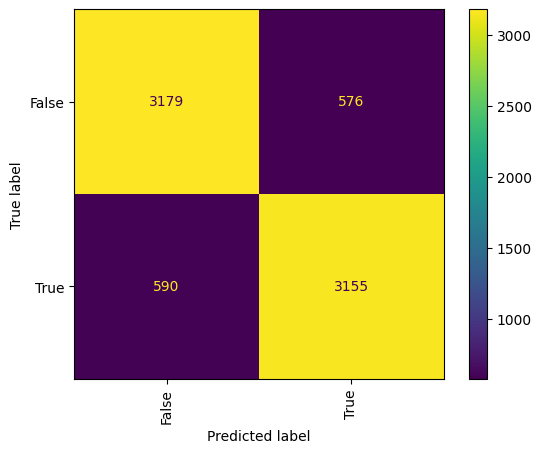

In [7]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
test(dtc)

### MultinomialBN

In [9]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

accuracy: 0.8749333333333333


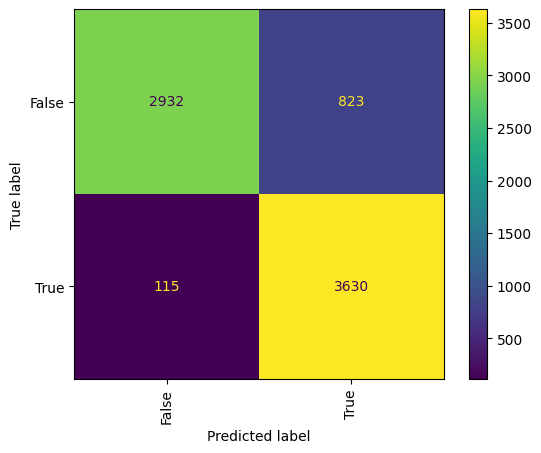

In [12]:
test(mnb)

Antes test

In [54]:
print(mnb.n_features_in_)

68741


Luego test

In [13]:
print(mnb.class_count_)

[21276. 21224.]


### BernoulliNB

accuracy: 0.7898666666666667
[21276. 21224.]


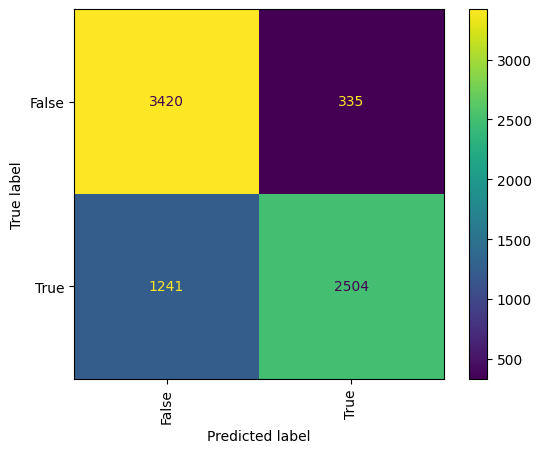

In [23]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
test(bnb)
print(bnb.class_count_)

### Logistic Regression

accuracy: 0.922


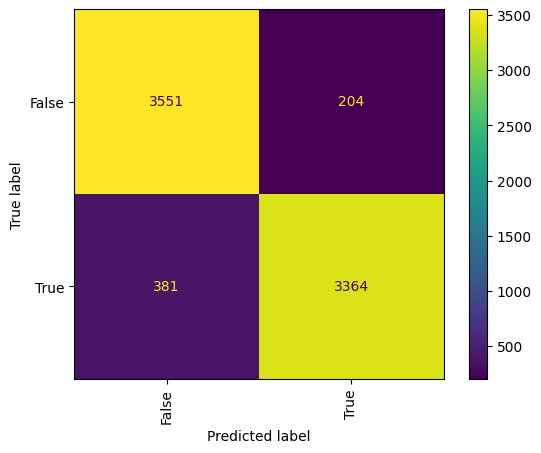

In [49]:
from sklearn.linear_model import LogisticRegression
# lgr = LogisticRegression()
lgr = LogisticRegression(max_iter=1000)
test(lgr)

### Naive Bayes

accuracy: 0.7736
[21276. 21224.]


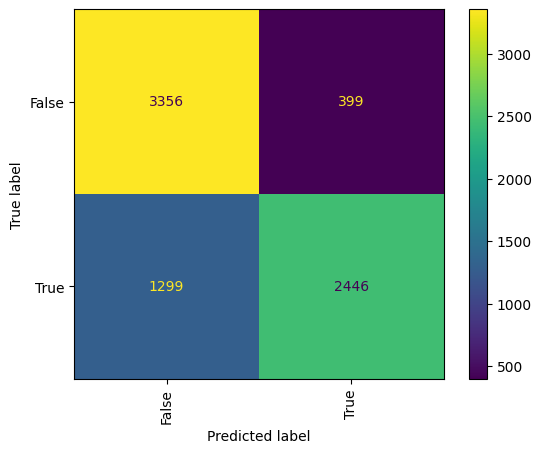

In [41]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
test(gnb)
print(gnb.class_count_)

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=42)
test(clf)

## Guardado

In [50]:
# verificar si ya existe una carpeta en dump o joblib con el nombre del modelo que se esta guardando
# decision_tree         -> dtc
# multinomial           -> mnb
# bernoulli             -> bnb
# gausian               -> gnb
# logistic_regression   -> lgr
# logistic_regression_more_iterations   -> lgr
nombre_modelo = 'logistic_regression_more_iterations'
# usar formato '25k' para 25.000 filas ejemplo
cant_filas = '50k'

In [51]:
path_joblib = '..\\entrenados\\'+ nombre_modelo + '\\joblib\\' + nombre_modelo + '_' + cant_filas
path_dump = '..\\entrenados\\'+ nombre_modelo + '\\dump\\' + nombre_modelo + '_' + cant_filas

Una version - USAR ESTE

In [52]:
joblib.dump(gnb, path_joblib +  '_model.pkl')
joblib.dump(count_vectorizer, path_joblib + '_vector.pkl')

['..\\entrenados\\logistic_regression_more_iterations\\joblib\\logistic_regression_more_iterations_50k_vector.pkl']

El que teniamos - O USAR ESTE

In [53]:
pickle.dump(gnb, open(path_dump +  '_model.pkl', 'wb'))
pickle.dump(count_vectorizer, open(path_dump +  '_vector.pkl', 'wb'))

## Casos de uso

### Si uso el que recien genere

In [ ]:
vect = count_vectorizer
model = lgr

### Si uso uno ya entrenado

In [ ]:
# verificar si ya existe una carpeta en dump o joblib con el nombre del modelo que se esta guardando
nombre_modelo = 'logistic_regression_more_iterations'
# usar formato '25k' para 25.000 filas ejemplo
cant_filas = '25k'

In [ ]:
path_joblib = '..\\entrenados\\'+ nombre_modelo + '\\joblib\\' + nombre_modelo + '_' + cant_filas
path_dump = '..\\entrenados\\'+ nombre_modelo + '\\dump\\' + nombre_modelo + '_' + cant_filas

Una version - USAR ESTE

In [ ]:
loaded_model = joblib.load(path_joblib + '_model.pkl')
loaded_count_vectorizer = joblib.load(path_joblib + '_vector.pkl')


El que teniamos - O USAR ESTE

In [ ]:
loaded_model = pickle.load(open(path_dump + '_model.pkl', 'rb'))
loaded_count_vectorizer = pickle.load(open(path_dump + '_vector.pkl', 'rb'))

Asigno a las variables lo cargado

In [ ]:
vect = loaded_count_vectorizer
model = loaded_model

### Usando un dataset

In [ ]:
file_path = '..\\datasets\\Suicide_Detection.csv'

dataframeTest = pd.read_csv(file_path, skiprows=50000, nrows=5000)
dataframeTest.columns = ["borrar","text","class"]
dataframeTest = dataframeTest.drop("borrar", axis=1)
dataframeTest['class'] = dataframeTest['class'].replace({"suicide": True, "non-suicide": False})

print(dataframeTest)

In [ ]:
counter = 0

for index, row in dataframeTest.iterrows():
    texto = row['text']
    
    # translator = Translator()
    # traduccion = translator.translate(texto, dest='es').text
    

    texto_preprocesado = preprocessing_function(texto)
    texto_preprocesado_str = ' '.join(texto_preprocesado)

    texto_vectorizado = vect.transform([texto_preprocesado_str])

    prediccion = model.predict(texto_vectorizado)

    clase_real = row['class']
    resultado_prediccion = 'suicida' if prediccion else 'no suicida'
    resultado_real = 'suicida' if clase_real else 'no suicida'

    if resultado_real != resultado_prediccion :
        counter = counter + 1
        print("----------------")
        print(texto)
        print("Dato dataset " + resultado_real)
        print("Dato prediccion " + resultado_prediccion)
    
    # Imprimir el resultado de la predicción y la clase real
    # print(f"Predicción: {resultado_prediccion}. Clase real: {resultado_real}\n")

print("La cantidad de casos donde no coincidio la prediccion con la clasificacion real del dataset: " + counter)

### Test manual

In [ ]:
textos_prueba = [
                "I want to jump from a bridge",
                "I want to suicide me",
                 "I hate my parents with all my heart",
                 "I hate all about this life",
                 "I cry every night",
                 "I don't know what is happen to me, but I don't want live anymore"
                 ]

translator = Translator()

for texto in textos_prueba:
    traduccion = translator.translate(texto, dest='es').text
    print(traduccion)

    texto_preprocesado = preprocessing_function(texto)
    texto_preprocesado_str = ' '.join(texto_preprocesado)

    # decision tree
    texto_vectorizado = vect.transform([texto_preprocesado_str])
    # descomentar si uso naive bayes
    # texto_vectorizado = texto_vectorizado.toarray()

    prediccion = model.predict(texto_vectorizado)

    print(f"Predicción para el texto '{texto}': {'suicida' if prediccion else 'no suicida'}\n\n")

## Verificar ocurrencia de palabras

### Palabras mas comunes contando palabra por palabra

In [ ]:
# Intuición principal en este tipo de tecnicas: Contar las ocurrencias de las palabras.
from collections import defaultdict, Counter
from tqdm import tqdm

# Instanciamos un contador de python
word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1]

    # Usamos la funcion implementada en pandas split() para separar palabras por espacios en blanco.
    for word in text.str.split()[0]:
        word_counts[word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(25)

### Palabras mas comunes contando con tokenizador

In [ ]:
from nltk import word_tokenize

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]
    for word in word_tokenize(text):
        word_counts[word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(25)

In [ ]:
print(("hello, how are you?").split())

In [ ]:
print(word_tokenize("hello, how are you?"))

### Palabras mas comunes contando teniendo en cuenta stopwords

In [ ]:
stopwords_en = stopwords.words('english')
print(stopwords_en)

In [ ]:
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

### Palabras mas comunes contando teniendo en cuenta signos de puntuacion

In [ ]:
from string import punctuation

# Hacemos una union entre conjunto de caracteres de puntuacion nativos a nuestro conjunto de stopwords usando la operation union de sets de datos.
stopwords_en = set(stopwords_en).union(set(punctuation))

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

### Stemming

In [ ]:
# Usamos Stemming
from nltk.stem import PorterStemmer

porter = PorterStemmer()

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            stemmed_word = porter.stem(word_lowercase)
            word_counts[stemmed_word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

### Lematization

In [ ]:
#Usemos Lemmatization:
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer


wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en:
            word_counts[word_lemmatized] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)